In [29]:
# Importing all the import libraries
!pip install opencv-python

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Loading the dataset in Google colab from drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Giving access of the datset in drive to google colab**

In [3]:
folder_path = '/content/drive/MyDrive/ColabNotebooks/chest_xray'
os.listdir(folder_path)

['__MACOSX', 'test', 'val', 'train']

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                # Check if the image was successfully read and resized
                if resized_arr is not None and resized_arr.shape == (img_size, img_size):
                    data.append([resized_arr, class_num])
                else:
                    print(f"Skipping image {img} due to incorrect shape or read error.")
            except Exception as e:
                print(e)
    # Convert data to a NumPy array
    # Stack images into a single array, and labels into another
    images = np.array([item[0] for item in data])
    labels_num = np.array([item[1] for item in data])
    # Return a tuple containing image array and label array
    return images, labels_num

In [7]:
train = get_training_data('/content/drive/MyDrive/ColabNotebooks/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/ColabNotebooks/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/ColabNotebooks/chest_xray/val')

**Data Visualization and Preprocessing**

<Axes: xlabel='count'>

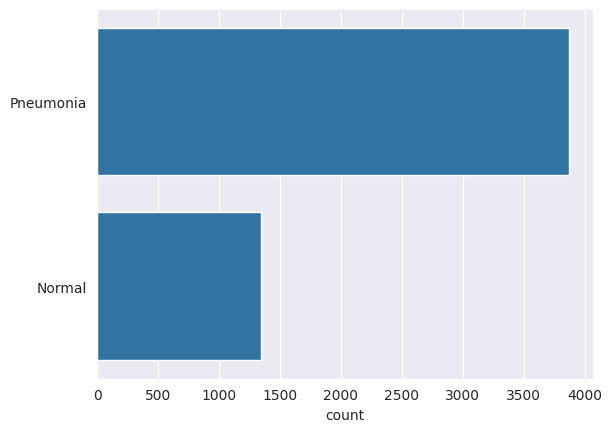

In [8]:
l = []

for i in train[1]:  # Iterate through the labels, not the entire training data
    if i == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

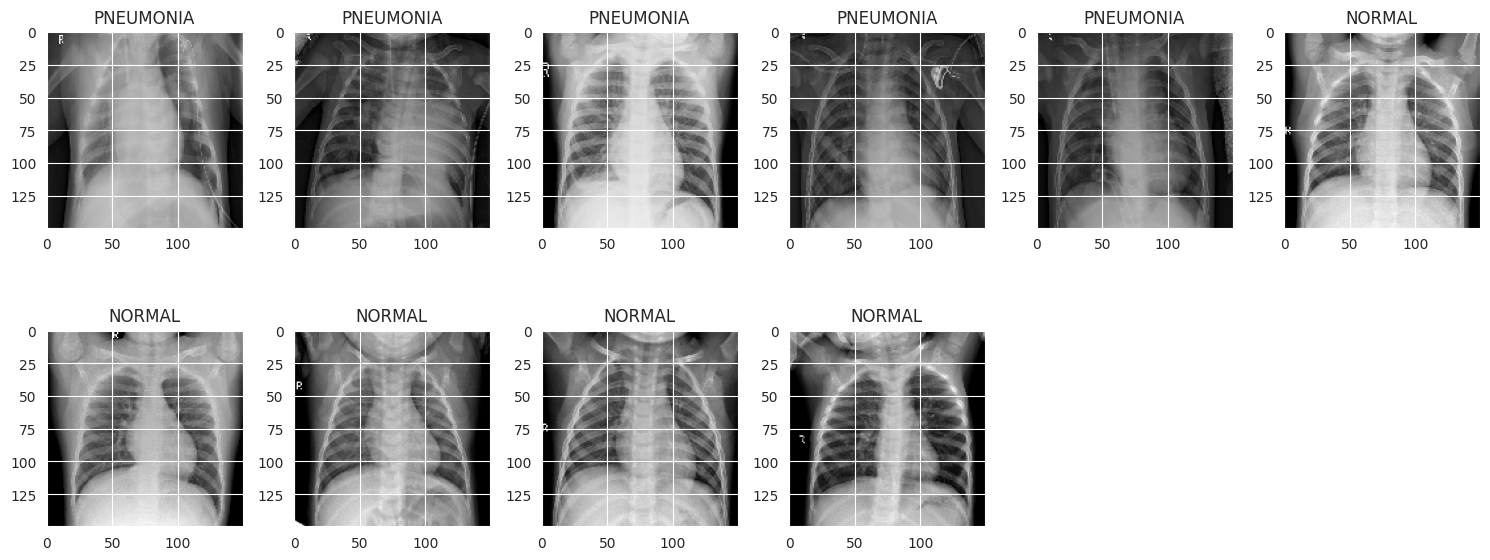

In [9]:
plt.figure(figsize=(15, 15))

# Create lists to hold images and labels
pneumonia_images = []
normal_images = []

# Separating images based on labels
for img, label in zip(train[0], train[1]):
    if label == 0:
        pneumonia_images.append(img)
    elif label == 1:
        normal_images.append(img)

# Plotting the first 5 images from each class
for i in range(5):
    # Pneumonia images
    plt.subplot(5, 6, i + 1)
    plt.imshow(pneumonia_images[i], cmap='gray')
    plt.title("PNEUMONIA")

    # Normal images
    plt.subplot(5, 6, i + 6)
    plt.imshow(normal_images[i], cmap='gray')
    plt.title("NORMAL")

plt.tight_layout()
plt.show()

In [10]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

# Access them using indexing
for feature in train[0]:  # Iterate through the features
    X_train.append(feature)
for label in train[1]:  # Iterate through the labels
    y_train.append(label)

# Apply similar logic for 'test' and 'val'
for feature in test[0]:
    X_test.append(feature)
for label in test[1]:
    y_test.append(label)

for feature in val[0]:
    X_val.append(feature)
for label in val[1]:
    y_val.append(label)

In [11]:
# We perform a grayscale normalization to reduce the effect of illumination's differences.
# Moreover the CNN converges faster on [0..1] data than on [0..255]
# Normalize the data

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [12]:
# resize data for deep learning

X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

**Data Augmentation**

In [13]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

**Training the Model**

In [21]:
model = Sequential([
    layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),

    layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),

    layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),

    layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),

    layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),

    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                               patience = 2,
                                                               verbose=1,
                                                               factor=0.3,
                                                               min_lr=0.000001)

history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,
                    epochs = 15 ,
                    validation_data = datagen.flow(X_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.8021 - loss: 0.9376 - val_accuracy: 0.5000 - val_loss: 17.7086 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8893 - loss: 0.2938 - val_accuracy: 0.5000 - val_loss: 40.6094 - learning_rate: 0.0010
Epoch 3/15
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9204 - loss: 0.2186
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9204 - loss: 0.2187 - val_accuracy: 0.5000 - val_loss: 27.8537 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9388 - loss: 0.1727 - val_accuracy: 0.5000 - val_loss: 19.2403 - learning_rate: 3.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.9511 - loss: 0.1354 - val_accuracy: 0.5625 - val_loss: 2.8857 - learning_rate: 3.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 

In [23]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9264 - loss: 0.1957
Loss of the model is -  0.24021251499652863
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9264 - loss: 0.1957
Accuracy of the model is -  91.02563858032227 %


**Analysis after Model Training**

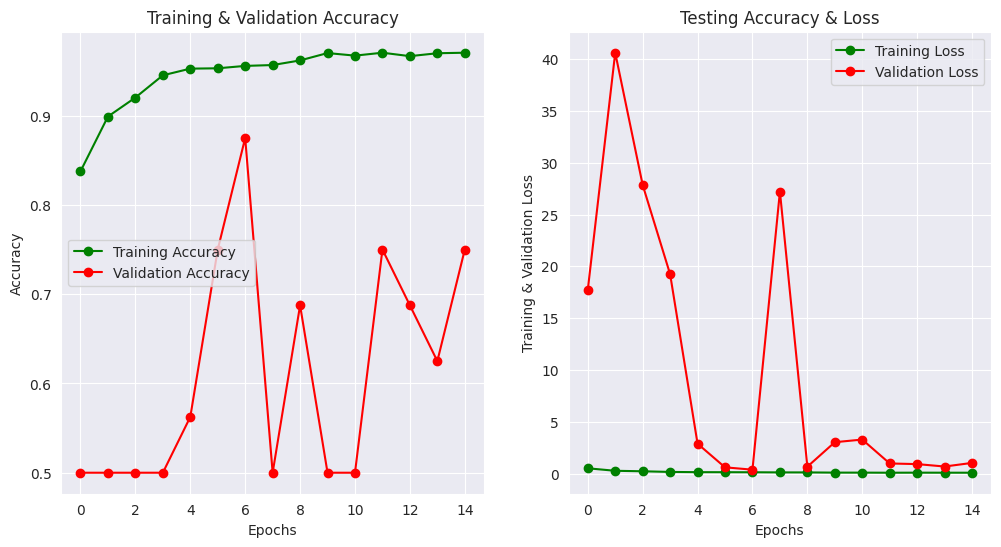

In [41]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = (model.predict(X_test) > 0.5).astype(int)  # Thresholding at 0.5
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.93      0.93       390
   Normal (Class 1)       0.88      0.88      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [27]:
cm = confusion_matrix(y_test,predictions)
cm

array([[363,  27],
       [ 29, 205]])

In [30]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

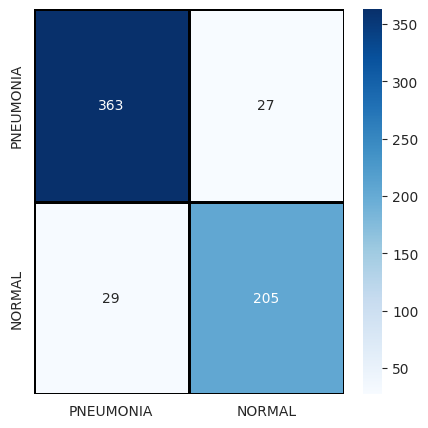

In [32]:
plt.figure(figsize = (5, 5))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

In [33]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

<ipython-input-38-c2b9ca7c8a71>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


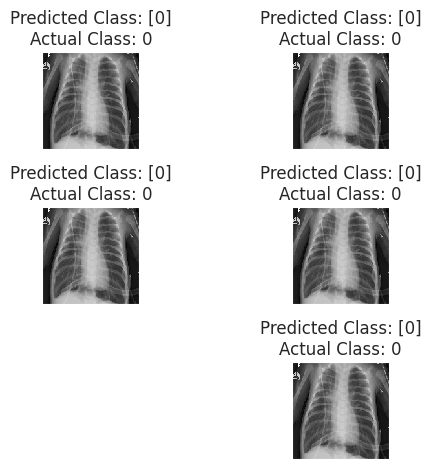

In [38]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class: {}\nActual Class: {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1